In [99]:
import pandas as pd
import seaborn as sns
import folium

# ACCIDENT

In [100]:
df_node = pd.read_csv('data/NODE.csv', sep=',')
print(df_node.shape, df_node.ACCIDENT_NO.nunique())
df_node = df_node.drop_duplicates(subset=['ACCIDENT_NO'])

(221797, 12) 202854


In [184]:
df = pd.read_csv('data/ACCIDENT.csv', sep=',',
    parse_dates=['ACCIDENTDATE', 'ACCIDENTTIME'])
print(df.shape)
df = df.merge(df_node[['ACCIDENT_NO', 'LGA_NAME', 'Lat', 'Long']], left_on='ACCIDENT_NO',right_on='ACCIDENT_NO', how='inner')
print(df.shape)
df['ACCIDENTTIME'] = df['ACCIDENTTIME'].apply(lambda x:x.hour)

foo = pd.read_csv('data/ROAD_SURFACE_COND.csv').drop_duplicates(subset=['ACCIDENT_NO'])
df = df.merge(foo[['ACCIDENT_NO', 'SURFACE_COND', 'Surface Cond Desc']], left_on='ACCIDENT_NO',right_on='ACCIDENT_NO', how='left')
print(df.shape)

foo = pd.read_csv('data/ACCIDENT_LOCATION.csv')
df = df.merge(foo[['ACCIDENT_NO', 'ROAD_NAME', 'ROAD_TYPE', 'ROAD_NAME_INT', 'ROAD_TYPE_INT']], left_on='ACCIDENT_NO',right_on='ACCIDENT_NO', how='left')
print(df.shape)

df.head()

(203708, 28)
(202854, 31)
(202854, 33)
(202854, 37)


ACCIDENT_NO ACCIDENTDATE  ACCIDENTTIME  ACCIDENT_TYPE  \
0  T20060000010   2006-01-13            12              1   
1  T20060000018   2006-01-13            19              1   
2  T20060000022   2006-01-14            12              7   
3  T20060000023   2006-01-14            11              1   
4  T20060000026   2006-01-14            10              1   

               Accident Type Desc  DAY_OF_WEEK Day Week Description  DCA_CODE  \
0          Collision with vehicle            6               Friday       113   
1          Collision with vehicle            6               Friday       113   
2  Fall from or in moving vehicle            7             Saturday       190   
3          Collision with vehicle            7             Saturday       130   
4          Collision with vehicle            7             Saturday       121   

                                  DCA Description DIRECTORY  ... SPEED_ZONE  \
0  RIGHT NEAR (INTERSECTIONS ONLY)                      MEL  ...         60   
1  RIGHT NEAR (INTERSECTIONS ONLY)                      MEL  ...         70   
2        FELL IN/FROM VEHICLE                           MEL  ...        100   
3  REAR END(VEHICLES IN SAME LANE)                      MEL  ...         80   
4           RIGHT THROUGH                               MEL  ...         50   

               LGA_NAME        Lat        Long  SURFACE_COND  \
0             DANDENONG -37.988622  145.218049             1   
1                 CASEY -37.990920  145.276320             1   
2  MORNINGTON PENINSULA -38.396320  144.854890             1   
3             DANDENONG -37.989185  145.144961             1   
4  MORNINGTON PENINSULA -38.372990  144.871594             1   

  Surface Cond Desc   ROAD_NAME  ROAD_TYPE    ROAD_NAME_INT  ROAD_TYPE_INT  
0               Dry      FOSTER     STREET           MCCRAE         STREET  
1               Dry      HALLAM       ROAD  BELGRAVE-HALLAM           ROAD  
2               Dry      BROWNS       ROAD         TRUEMANS           ROAD  
3               Dry  SPRINGVALE       ROAD      KEYSBOROUGH         AVENUE  
4               Dry   ELIZABETH     AVENUE        GREENHOOD       CRESCENT  

[5 rows x 37 columns]

In [185]:
toto = df[['SEVERITY', 'SPEED_ZONE', 'Road Geometry Desc']]
toto = toto[toto.SPEED_ZONE < 200]
toto['count'] = 1
bla = pd.pivot_table(index='SEVERITY', columns='SPEED_ZONE', data=toto, aggfunc=sum).fillna(0)
bla

count                                                          \
SPEED_ZONE    30      40       50       60      70    75       80     90    
SEVERITY                                                                    
1             2.0    46.0    330.0    704.0   248.0   2.0    568.0   35.0   
2            80.0  2408.0  11512.0  21665.0  5320.0  25.0   9955.0  417.0   
3           186.0  6475.0  24248.0  46636.0  9551.0  35.0  17176.0  486.0   
4             0.0     0.0      0.0      2.0     0.0   0.0      1.0    0.0   

                             
SPEED_ZONE      100     110  
SEVERITY                     
1            1611.0   125.0  
2           13214.0   840.0  
3           16093.0  1165.0  
4               0.0     0.0

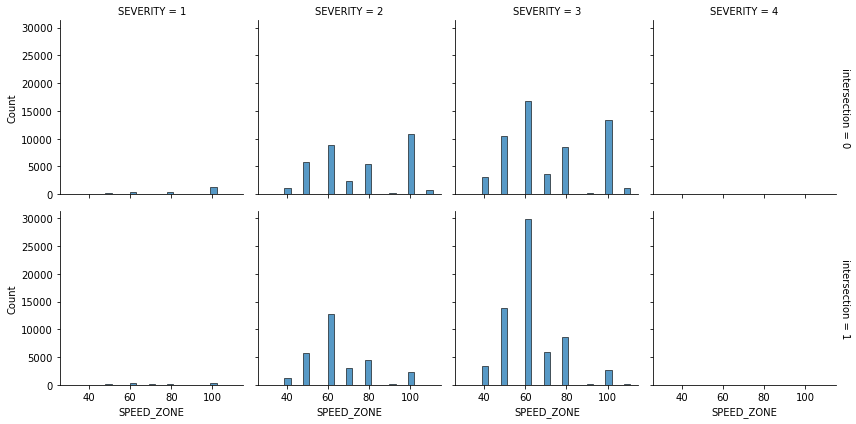

In [186]:
toto['intersection'] = 1 - toto['Road Geometry Desc'].str.contains('Not at intersection')
sns.displot(
    toto, x="SPEED_ZONE", col="SEVERITY", row="intersection",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True),
)

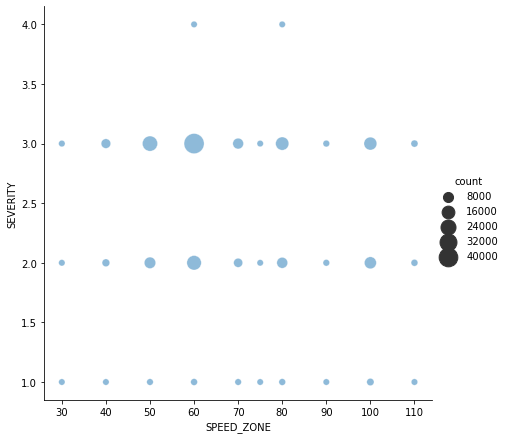

In [161]:
# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="SPEED_ZONE", y="SEVERITY", size="count",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6,
            data=toto.groupby(['SEVERITY', 'SPEED_ZONE']).sum().reset_index())

A sizeable portion of accidents happen in intersections (X,T or multi)
others mainly on straight roads

In [228]:
foo = df[['ROAD_TYPE', 'SEVERITY', 'ACCIDENTDATE']]
df['ACCIDENTYEAR'] = df['ACCIDENTDATE'].dt.year
foo = foo.groupby(['SEVERITY', 'ACCIDENTDATE']).size().reset_index().sort_values(0, ascending=False)

<AxesSubplot:xlabel='ACCIDENTYEAR', ylabel='Count'>

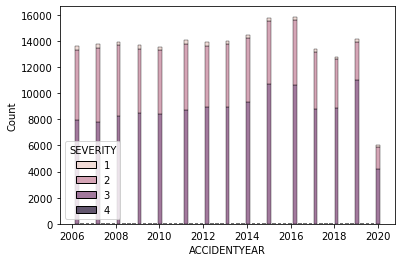

In [229]:
sns.histplot(x = "ACCIDENTYEAR" , hue = "SEVERITY",multiple = 'stack',data=df,shrink = 0.7)

In [231]:
import plotly.express as px
df['accident'] = 1
fig = px.histogram(df, x="ACCIDENTYEAR", y="dummy",
             color='SEVERITY', barmode='stack',
             height=400)
fig.show()

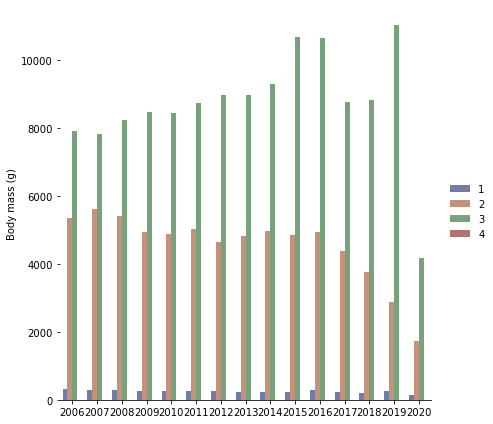

In [219]:

g = sns.catplot(
    data=foo, kind="bar",
    x="ACCIDENTDATE", y=0, hue="SEVERITY",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Body mass (g)")
g.legend.set_title("")

In [199]:
#Import the Lib
import folium
from folium.plugins import HeatMap

top_roads = df.groupby('ROAD_NAME').size().sort_values(ascending=False).head(30)
#Make the list of Lat an Lng
filtered = df[(df.ROAD_NAME.isin(top_roads.index)) & (df.ACCIDENTDATE.dt.year >= 2019)]

#Create the Map
map = folium.Map(
    location=[df.Lat.mean(), df.Long.mean()],
    tiles='cartodbdark_matter',
    zoom_start=11
)
HeatMap(list(zip(filtered.Lat, filtered.Long))).add_to(map)
map

# PERSON

In [2]:
cols = ['ACCIDENT_NO', 'PERSON_ID', 'VEHICLE_ID', 'SEX', 'AGE',
       'INJ_LEVEL', 'Inj Level Desc', 'SEATING_POSITION', 'HELMET_BELT_WORN',
       'ROAD_USER_TYPE', 'LICENCE_STATE',
       'PEDEST_MOVEMENT', 'POSTCODE', 'TAKEN_HOSPITAL']
dtype = [str, str, str, str, float, int, str, str, int, int, str, int, int, str]

df = pd.read_csv('data/PERSON.csv', sep=',',
    usecols=cols,
    na_values=[' ']
    )
df.head()

ACCIDENT_NO PERSON_ID VEHICLE_ID SEX   AGE  INJ_LEVEL Inj Level Desc  \
0  T20060000010        01          A   F   NaN        4.0    Not injured   
1  T20060000010        02          C   M  43.0        4.0    Not injured   
2  T20060000010        03          C   M  22.0        4.0    Not injured   
3  T20060000010        A           A   M  72.0        4.0    Not injured   
4  T20060000010        B           B   F  62.0        3.0   Other injury   

  SEATING_POSITION  HELMET_BELT_WORN ROAD_USER_TYPE LICENCE_STATE  \
0               LF               1.0              3           NaN   
1               LF               1.0              3           NaN   
2               LR               1.0              3           NaN   
3               D                1.0              2             V   
4               D                1.0              2             V   

   PEDEST_MOVEMENT  POSTCODE TAKEN_HOSPITAL  
0              0.0    3130.0            NaN  
1              0.0    7310.0            NaN  
2              0.0    7310.0            NaN  
3              0.0    3130.0            NaN  
4              0.0       NaN              N

In [35]:
for c in ['AGE', 'INJ_LEVEL', 'HELMET_BELT_WORN','ROAD_USER_TYPE', 'POSTCODE']:
    df[c] = pd.to_numeric(df[c], errors = 'coerce')


<AxesSubplot:>

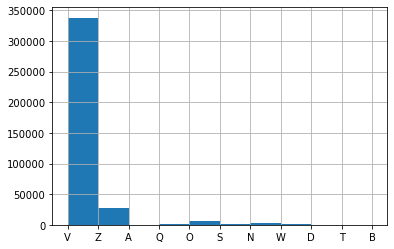

In [10]:
df.LICENCE_STATE.hist()

<AxesSubplot:>

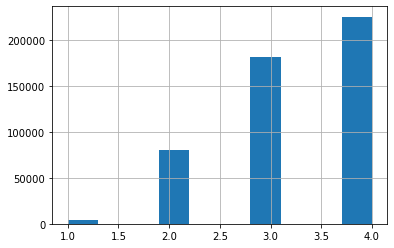

In [6]:
df.INJ_LEVEL.hist()

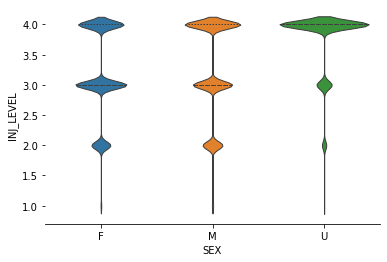

In [38]:
# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(data=df, x="SEX", y="INJ_LEVEL",
               split=True, inner="quart", linewidth=1)
sns.despine(left=True)

In [62]:
ddf = df.merge(df_node[['ACCIDENT_NO', 'LGA_NAME', 'Lat', 'Long']], left_on='ACCIDENT_NO',right_on='ACCIDENT_NO')

In [179]:
m = folium.Map(location=[ddf.Lat.mean(), ddf.Long.mean()], tiles="Stamen Toner")
m

NameError: name 'ddf' is not defined

In [76]:
toto = pd.DataFrame(ddf.LGA_NAME.value_counts()).reset_index()
toto.columns = ['Region', 'Number of accidents']
toto['Region'] = toto['Region'].apply(lambda x: x.strip('(').strip(')'))

In [77]:
toto

Region  Number of accidents
0                   MELBOURNE                39114
1                       CASEY                23101
2                   DANDENONG                20127
3                      MONASH                19453
4                     GEELONG                18976
..                        ...                  ...
83              LAKE MOUNTAIN                   34
84              MOUNT BAW BAW                   25
85              FRENCH ISLAND                    6
86             MOUNT STIRLING                    4
87  MOUNT BULLER ALPINE RESOR                    2

[88 rows x 2 columns]

In [81]:

state_geo = f"https://data.gov.au/dataset/ds-dga-bdf92691-c6fe-42b9-a0e2-a4cd716fa811/distribution/dist-dga-ce0a0ed3-6003-47fd-88ad-4b49d9337d47/?q="

state_data = ddf[['LGA_NAME']].value_counts()

from urllib.request import urlopen
import json
with urlopen(state_geo) as response:
    counties = json.load(response)

import plotly.express as px

fig = px.choropleth(state_data, geojson=counties, locations='fips', color='unemp',
                           color_continuous_scale="Viridis",
                           range_color=(0, 12),
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

m

JSONDecodeError: Expecting value: line 7 column 1 (char 6)

In [75]:
'(x)'.strip('(').strip(')')

'x'

# LOCATION

In [174]:
loc = pd.read_csv('data/ACCIDENT_LOCATION.csv')
print(loc.shape)
loc.head()

(203708, 11)


ACCIDENT_NO  NODE_ID  ROAD_ROUTE_1   ROAD_NAME ROAD_TYPE    ROAD_NAME_INT  \
0  T20060000010    43078        2090.0      FOSTER    STREET           MCCRAE   
1  T20060000018    29720        5057.0      HALLAM      ROAD  BELGRAVE-HALLAM   
2  T20060000022   203074        9999.0      BROWNS      ROAD         TRUEMANS   
3  T20060000023    55462        2400.0  SPRINGVALE      ROAD      KEYSBOROUGH   
4  T20060000026   202988        9999.0   ELIZABETH    AVENUE        GREENHOOD   

  ROAD_TYPE_INT  DISTANCE_LOCATION DIRECTION_LOCATION  NEAREST_KM_POST  \
0        STREET                0.0                 SW              NaN   
1          ROAD               70.0                  S              NaN   
2          ROAD              210.0                  W              NaN   
3        AVENUE                0.0                  N              NaN   
4      CRESCENT               20.0                  N              NaN   

  OFF_ROAD_LOCATION  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN

<AxesSubplot:xlabel='ROAD_NAME'>

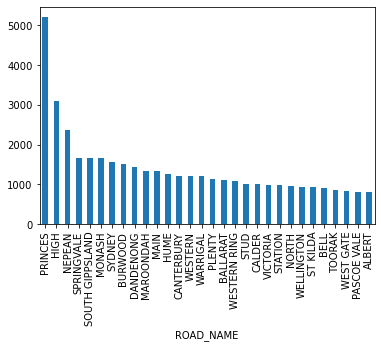

In [182]:
top_roads = loc.groupby('ROAD_NAME').size().sort_values(ascending=False).head(30)
top_roads.plot(kind='bar')

In [183]:
top_roads.index

Index(['PRINCES', 'HIGH', 'NEPEAN', 'SPRINGVALE', 'SOUTH GIPPSLAND', 'MONASH',
       'SYDNEY', 'BURWOOD', 'DANDENONG', 'MAROONDAH', 'MAIN', 'HUME',
       'CANTERBURY', 'WESTERN', 'WARRIGAL', 'PLENTY', 'BALLARAT',
       'WESTERN RING', 'STUD', 'CALDER', 'VICTORIA', 'STATION', 'NORTH',
       'WELLINGTON', 'ST KILDA', 'BELL', 'TOORAK', 'WEST GATE', 'PASCOE VALE',
       'ALBERT'],
      dtype='object', name='ROAD_NAME')